# YouTube Premium Japan Q1 2020

## Selection of Exposed Markets for MMT

### Approach

Need to choose the markets to put into the following cells
1. DR BAU + Brand Campaign
2. DR BAU

If possible
3. DR BAU + DR w/ Brand Creatives

EACH CELL NEEDS TO HAVE 20% OF __SIGN UPs__!

Since we can't predict how many sign ups it will have, we can go with 20% of population, and assume that sign up rate is similar enough to population.

#### Import libraries

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from authentication.authenticator import Authenticator
from sheets.sheetmanager import SheetManager

#### Initialize necessary strings

In [27]:
keys = 'credentials.json'
SCOPES = ['https://www.googleapis.com/auth/drive.readonly']

spreadsheetId = '1QbkOSgaHt75LeQY2a9GeUjHajXIHWv3Z-ID7svUPG6w'
dav_data_range = 'JP'
cce_data_range = 'CCE Split - JP by region!A2:D50'
pop_data_range = 'Population by Prefecture!O5:Q52'
age_data_range = 'Population by Prefecture by Age Group!B5:Y53'

su_spreadsheetId = '1LaRfoYATost1I7O0yhIrtY9pFZ7cDbGdp-G1TIHYaYs'
su_data_range = 'YTP Only'
su_date_start = '2018-11-23'
su_date_end = '2019-11-23'

#### Authenticate and Initialize Manager to work with Google Sheets

In [28]:
authenticator = Authenticator(keys)
creds = authenticator.get_creds(SCOPES)
manager = SheetManager(creds)

#### Load in data from G sheets as pandas dataframes

In [29]:
# load in the dav figures
dav_df = manager.get_values(spreadsheetId=spreadsheetId,
                            data_range=dav_data_range,
                            )

dav_df = dav_df[dav_df['region_name'] != 'null']
dav_df['date'] = pd.to_datetime(dav_df['date'], format='%Y%m%d')
dav_df = dav_df.set_index('region_name')

r_df = dav_df.reset_index()[['date', 'region_name', 'total']]
r_df.to_csv('dav_data.csv', index=False, encoding='utf-8-sig')
#r_df.to_csv('dav_data.csv', index=False)
#r_df.head()

In [30]:
# load in the cce split
cce_df = manager.get_values(spreadsheetId=spreadsheetId,
                                data_range=cce_data_range,
                                as_df=True)

cce_df = cce_df[cce_df['region_name'] != 'null']
cce_df = cce_df.set_index('region_name')

In [31]:
# load in pop figures
pop_df = manager.get_values(spreadsheetId=spreadsheetId,
                           data_range=pop_data_range)

pop_df = pop_df.set_index('region_name')

In [32]:
# load in age figures

age_df = manager.get_values(spreadsheetId=spreadsheetId,
                           data_range=age_data_range)

age_df = age_df[age_df['Prefecture in EN'] != 'Total']
age_df = age_df.set_index('Prefecture in EN')

# we only want 18-54

age_df = age_df[['15～19歳', '20～24歳', '25～29歳', '30～34歳', '35～39歳', '40～44歳', '45～49歳', '50～54歳']]
age_df = age_df.rename(columns={'15～19歳': '15-19',
                                '20～24歳': '20-24',
                                '25～29歳': '25-29',
                                '30～34歳': '30-34',
                                '35～39歳': '35-39',
                                '40～44歳': '40-44',
                                '45～49歳': '45-49',
                                '50～54歳': '50-54'})

#### Read in the Sign-up Data and clean it if necessary
 Then export it out as a csv for the R script

          Day                Region  Signups
0  2-Jan-2018        Mie Prefecture        0
1  2-Jan-2018      Chiba Prefecture        0
2  2-Jan-2018   Nagasaki Prefecture        0
3  2-Jan-2018  Tokushima Prefecture        0
4  2-Jan-2018   Hokkaido Prefecture        0


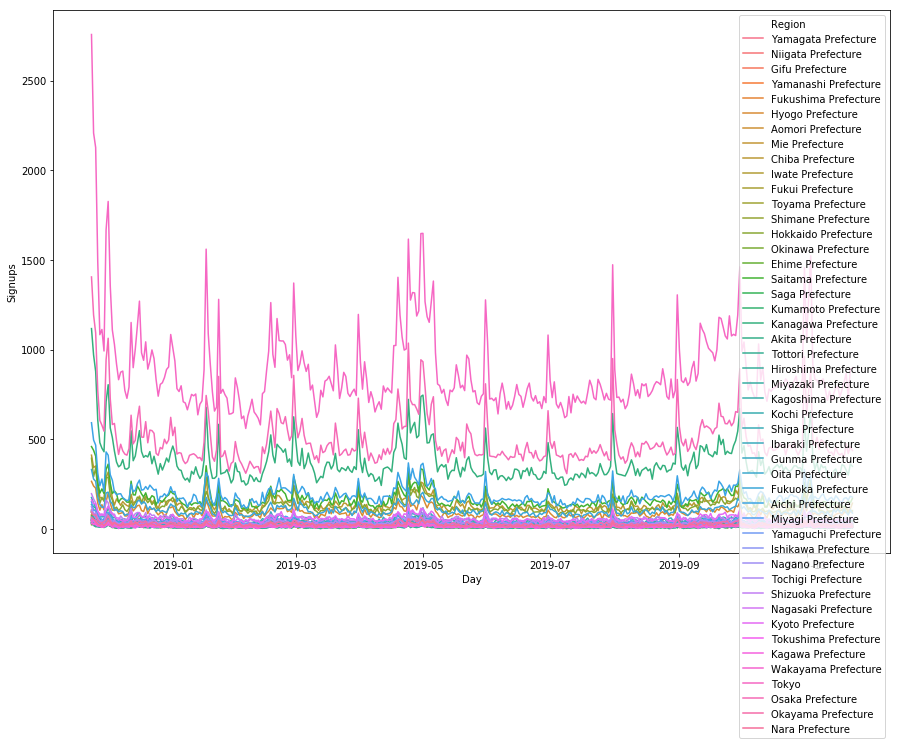

In [33]:
su_df = manager.get_values(spreadsheetId=su_spreadsheetId,
                          data_range=su_data_range)

print(su_df.head())

su_df['Day'] = pd.to_datetime(su_df['Day'])
# filter for time period
su_df = su_df[(su_df['Day'] >= su_date_start) & (su_df['Day'] <= su_date_end)]

# save as csv for the R script
su_df.to_csv('signups.csv', index=False)

fig = plt.figure(num=None,
                    figsize=(15, 10))
ax = fig.gca()

sns.lineplot(x='Day', y='Signups', hue='Region', data=su_df, ax=ax)

#### Pivot the DAV table so that index is the regions

In [34]:
#dav_df = dav_df.pivot_table(values=['unique_logged_in_dav', 'unique_visitor_dav', 'total'],
#                            index='region_name',
#                            columns='date')

table = dav_df.pivot_table(values=['unique_logged_in_dav', 'unique_visitor_dav', 'total'],
                            index='region_name',
                            aggfunc=np.mean)


#### Merge all dataframes together so that we have data by region in one dataframe

In [35]:
df = table.merge(cce_df, how='outer', left_index=True, right_index=True)
df = df.merge(pop_df, how='outer', left_index=True, right_index=True)
df = df.merge(age_df, how='outer', left_index=True, right_index=True)
df = df.rename(columns={'total': 'Average Total DAV',
               'unique_logged_in_dav': 'Average Unique Logged in DAV',
               'unique_visitor_dav': 'Average Unique Visitor DAV',
               'Casual': 'Casual Users Proportion',
               'Core': 'Core Users Proportion',
               'Emerging': 'Emerging Users Proportion',})

#df['Internet Population'] = df['General Populations'] * df['Internet Penetration (%)'] / 100
#df['YT penetration (of internet)'] = df['Average Total DAV'] / df['Internet Population']
#df['YT penetration (of population)'] = df['Average Total DAV'] / df['General Populations']
df['15-34'] = df['15-19'] + df['20-24'] + df['25-29'] + df['30-34']
df['HYU DAV'] = df['Average Total DAV'] * df['Core Users Proportion']
df['Internet Population'] = (df['Internet Penetration (%)']/100) * df['General Populations']

# order by Gen Pop and then get cumulative numbers

df = df.sort_values('HYU DAV', ascending=False)

df['HYU DAV (Cumulative)'] = df['HYU DAV'].cumsum()
df['HYU DAV (Cumulative) %'] = df['HYU DAV (Cumulative)']/df['HYU DAV'].sum()*100

df['Internet Population (Cumulative)'] = df['Internet Population'].cumsum()
df['Internet Population (Cumulative) %'] = df['Internet Population (Cumulative)']/df['Internet Population'].sum()*100

df['General Population (Cumulative)'] = df['General Populations'].cumsum()
df['General Population (Cumulative) %'] = df['General Population (Cumulative)']/df['General Populations'].sum()*100

# rename index to get rid of the funny characters
print('Old Index:')
print(df.index.tolist())

new_index = ['Tokyo', 'Osaka Prefecture', 'Kanagawa Prefecture', 'Aichi Prefecture', 'Saitama Prefecture',
             'Chiba Prefecture', 'Hokkaido Prefecture', 'Fukuoka Prefecture', 'Hyogo Prefecture', 'Shizuoka Prefecture',
             'Ibaraki Prefecture', 'Kyoto Prefecture', 'Hiroshima Prefecture', 'Miyagi Prefecture', 'Niigata Prefecture',
             'Tochigi Prefecture', 'Gunma Prefecture', 'Gifu Prefecture', 'Nagano Prefecture', 'Okayama Prefecture',
             'Fukushima Prefecture', 'Mie Prefecture', 'Kumamoto Prefecture', 'Okinawa Prefecture', 'Shiga Prefecture',
             'Nara Prefecture', 'Ehime Prefecture', 'Kagoshima Prefecture', 'Yamaguchi Prefecture', 'Aomori Prefecture',
             'Nagasaki Prefecture', 'Ishikawa Prefecture', 'Oita Prefecture', 'Miyazaki Prefecture', 'Iwate Prefecture',
             'Toyama Prefecture', 'Yamagata Prefecture', 'Kagawa Prefecture', 'Wakayama Prefecture', 'Yamanashi Prefecture',
             'Fukui Prefecture', 'Akita Prefecture', 'Tokushima Prefecture', 'Saga Prefecture', 'Kochi Prefecture',
             'Shimane Prefecture', 'Tottori Prefecture']

df.index = pd.Index(new_index)

df

df.to_csv('results.csv')

Old Index:
['Tokyo', 'Osaka Prefecture', 'Kanagawa Prefecture', 'Aichi Prefecture', 'Saitama Prefecture', 'Chiba Prefecture', 'Hokkaido Prefecture', 'Fukuoka Prefecture', 'Hyōgo Prefecture', 'Shizuoka Prefecture', 'Ibaraki Prefecture', 'Kyoto Prefecture', 'Hiroshima Prefecture', 'Miyagi Prefecture', 'Niigata Prefecture', 'Tochigi Prefecture', 'Gunma Prefecture', 'Gifu Prefecture', 'Nagano Prefecture', 'Okayama Prefecture', 'Fukushima Prefecture', 'Mie Prefecture', 'Kumamoto Prefecture', 'Okinawa Prefecture', 'Shiga Prefecture', 'Nara Prefecture', 'Ehime Prefecture', 'Kagoshima Prefecture', 'Yamaguchi Prefecture', 'Aomori Prefecture', 'Nagasaki Prefecture', 'Ishikawa Prefecture', 'Ōita Prefecture', 'Miyazaki Prefecture', 'Iwate Prefecture', 'Toyama Prefecture', 'Yamagata Prefecture', 'Kagawa Prefecture', 'Wakayama Prefecture', 'Yamanashi Prefecture', 'Fukui Prefecture', 'Akita Prefecture', 'Tokushima Prefecture', 'Saga Prefecture', 'Kōchi Prefecture', 'Shimane Prefecture', 'Tottori Pref

## STOP

At this point, you must have run the R Match Market script to get a csv of all the match combinations

### Load in the market match results

#### Need to select best controls for our selected exposed markets above

These are the approved guidelines:
1. Within the top 30 percentile for lowest dynamic time warped distance
2. Market pair correlation of >90%
3. Mean correlation with other markets >50%

Approach:
1. Find markets that 1) have correlations with other markets at >90%; 2) have DTW distances with other markets that are in the top 30 percentile for lowest distance
2. These markets become "viable controls"
3. Test that the mean correlation with other markets for each of these controls is >50%
4. Go through these control markets, starting from those with the most pairs, and select as many as necessary until 20% Internet Population (which, as mentioned, we will assumed correlates with number of sign-ups to meet Nate's request of 20% sign up per cell
5. For each of the remaining (non-control) markets, get mean correlation with the selected controls. Pick from the best matches till 20% of Internet Population to form exposed cell.
6. Back test to validate selection
7. Find Non-study group that will add up with the exposed group to form 70% HYUs

### Approach Execution

#### Find markets that 
1. have correlations with other markets at >90%
2. have DTW distances with other markets that are in the top 30 percentile for lowest distance

In [36]:
mm_df = pd.read_csv('MM_results.csv')
mm_df = mm_df[['Region', 'ComparedRegion', 'rank', 'RelativeDistance', 'Correlation']]

# 90% correlation too restrictive, 80% instead
correlation_req = 0.8
percentile_req = 0.3

a2_mm_df = mm_df[(mm_df['Correlation'] > correlation_req) & (mm_df['RelativeDistance'] < mm_df['RelativeDistance'].quantile(percentile_req))]
print(a2_mm_df)

print(a2_mm_df['ComparedRegion'].value_counts().reset_index())



                    Region        ComparedRegion  rank  RelativeDistance  \
0         Aichi Prefecture    Saitama Prefecture     1          0.196704   
1         Aichi Prefecture      Chiba Prefecture     2          0.387649   
2         Aichi Prefecture   Hokkaido Prefecture     3          0.534232   
138       Chiba Prefecture   Hokkaido Prefecture     1          0.172861   
139       Chiba Prefecture    Saitama Prefecture     2          0.278338   
140       Chiba Prefecture    Fukuoka Prefecture     3          0.358756   
141       Chiba Prefecture      Hyogo Prefecture     4          0.528241   
142       Chiba Prefecture      Aichi Prefecture     5          0.528804   
276     Fukuoka Prefecture      Hyogo Prefecture     1          0.201999   
277     Fukuoka Prefecture   Hokkaido Prefecture     2          0.295957   
278     Fukuoka Prefecture      Chiba Prefecture     3          0.481529   
386        Gifu Prefecture     Miyagi Prefecture    19          0.624245   
460   Hirosh

#### These markets are viable controls

In [37]:
viable_controls = a2_mm_df['ComparedRegion'].value_counts().reset_index()['index'].tolist()
print('Viable control regions:')
for region in viable_controls:
    print(region)
print()

Viable control regions:
Miyagi Prefecture
Ibaraki Prefecture
Hokkaido Prefecture
Shizuoka Prefecture
Chiba Prefecture
Hiroshima Prefecture
Kyoto Prefecture
Fukuoka Prefecture
Saitama Prefecture
Tochigi Prefecture
Hyogo Prefecture
Aichi Prefecture
Kanagawa Prefecture
Gifu Prefecture
Nagano Prefecture
Osaka Prefecture



#### Test that the mean correlation with other markets for each of these controls is >50%

In [38]:
print('Table of mean correlations')
print(mm_df[mm_df['Region'].isin(viable_controls)].pivot_table(values='Correlation',
                                                                    index='Region',
                                                                   aggfunc=np.mean).sort_values('Correlation', ascending=False))



Table of mean correlations
                      Correlation
Region                           
Kanagawa Prefecture      0.809542
Osaka Prefecture         0.802779
Saitama Prefecture       0.798552
Aichi Prefecture         0.797630
Hokkaido Prefecture      0.794134
Chiba Prefecture         0.787411
Fukuoka Prefecture       0.785742
Hyogo Prefecture         0.778917
Ibaraki Prefecture       0.754111
Shizuoka Prefecture      0.753260
Kyoto Prefecture         0.750167
Hiroshima Prefecture     0.749099
Miyagi Prefecture        0.746912
Tochigi Prefecture       0.734854
Nagano Prefecture        0.720616
Gifu Prefecture          0.713808


Go through these control markets, starting from those with the most pairs, and select as many as necessary until 20% or historical signups

In [41]:
print('% of internet pop for the following regions:')
print()

viable_controls_df = su_df.groupby('Region').sum().filter(items=viable_controls, axis=0).reset_index()
viable_controls_df['Cum. Historical Signups %'] = viable_controls_df['Signups'].cumsum()*100/su_df['Signups'].sum()
print(viable_controls_df)

#viable_controls_df = df.filter(items=viable_controls, axis=0)['Internet Population'].reset_index()
#viable_controls_df['Cum. Internet Population %'] = viable_controls_df['Internet Population'].cumsum() * 100 / df['Internet Population'].sum()
#print(viable_controls_df)



        


% of internet pop for the following regions:

                  Region  Signups  Cum. Historical Signups %
0      Miyagi Prefecture    15789                   1.231955
1     Ibaraki Prefecture    19985                   2.791309
2    Hokkaido Prefecture    46271                   6.401659
3    Shizuoka Prefecture    21565                   8.084293
4       Chiba Prefecture    51556                  12.107011
5   Hiroshima Prefecture    16031                  13.357849
6       Kyoto Prefecture    21683                  15.049691
7     Fukuoka Prefecture    38411                  18.046755
8     Saitama Prefecture    61468                  22.842869
9     Tochigi Prefecture    13132                  23.867508
10      Hyogo Prefecture    33377                  26.471788
11      Aichi Prefecture    70329                  31.959292
12   Kanagawa Prefecture   136481                  42.608384
13       Gifu Prefecture    10922                  43.460586
14     Nagano Prefecture    12091      

#### Selected Controls

In [43]:
# looks like ['Miyagi Prefecture', 'Ibaraki Prefecture', 'Hokkaido Prefecture', 'Kyoto Prefecture',
#             'Hiroshima Prefecture', 'Fukuoka Prefecture', 'Chiba Prefecture', 'Shizuoka Prefecture'] for 24%

# using the above as controls, find the best exposed markets that will add up to 70% HYUs


selected_controls = ['Miyagi Prefecture', 'Ibaraki Prefecture', 'Hokkaido Prefecture', 'Shizuoka Prefecture',
                     'Chiba Prefecture', 'Hiroshima Prefecture', 'Kyoto Prefecture', 'Fukuoka Prefecture',
                     'Saitama Prefecture']


#### For each of the remaining (non-control) markets, get mean correlation with the selected controls. Pick from the best matches till 20% of Historical Signups to form exposed cell.


In [45]:
control_pairs_df = mm_df[mm_df['ComparedRegion'].isin(selected_controls)].sort_values(['Region', 'rank'])
control_pairs_df = mm_df[~mm_df['Region'].isin(selected_controls)]

control_pairs_means = control_pairs_df.groupby('Region').mean()[['Correlation', 'RelativeDistance']].sort_values('Correlation', ascending=False)
print('Correlation top 10 ranking')
print(control_pairs_means.head(10))
print()
print('% of historical signups for the following regions (top 20):')
print()
viable_exposed = control_pairs_means.reset_index()['Region'].tolist()


viable_exposed_df = su_df.groupby('Region').sum().filter(items=viable_exposed, axis=0).reset_index()
viable_exposed_df['Cum. Historical Signups %'] = viable_exposed_df['Signups'].cumsum()*100/su_df['Signups'].sum()
print(viable_exposed_df)





Correlation top 10 ranking
                      Correlation  RelativeDistance
Region                                             
Tokyo                    0.811582          1.768818
Kanagawa Prefecture      0.809542          1.658379
Osaka Prefecture         0.802779          1.688225
Aichi Prefecture         0.797630          1.631883
Hyogo Prefecture         0.778917          1.831243
Niigata Prefecture       0.737913          3.190888
Tochigi Prefecture       0.734854          3.130945
Okayama Prefecture       0.731110          3.736568
Fukushima Prefecture     0.725716          3.633304
Nagano Prefecture        0.720616          3.358731

% of historical signups for the following regions (top 20):

                  Region  Signups  Cum. Historical Signups %
0                  Tokyo   323363                  25.230782
1    Kanagawa Prefecture   136481                  35.879874
2       Osaka Prefecture   181649                  50.053253
3       Aichi Prefecture    70329          

#### Selected Exposed

In [46]:
# Tokyo alone is already more than 20%, so we will pick those with correlations above 80%

selected_exposed = ['Tokyo', 'Kanagawa Prefecture', 'Osaka Prefecture']
        


# STOP

Now that you have Selected Controls and Exposed for the MMT, run a causal impact Back test on R

In [19]:
#### Now we need to add prefectures to our exposed list to make up 70% of HYUs so that we can scale for the budget

In [47]:
# 7. add prefectures starting from those with highest HYUs until Exposed + Non-study = 70% HYUs

invalid_prefectures = selected_controls.copy()
invalid_prefectures.extend(selected_exposed)

remaining_prefectures_df = df.drop(labels=invalid_prefectures).sort_values('HYU DAV', ascending=False)
remaining_prefectures = remaining_prefectures_df.index.tolist()

agg_selected_exposed = df.filter(items=selected_exposed, axis=0)['HYU DAV'].reset_index()

new_remaining_prefectures_df = pd.concat([agg_selected_exposed, df.filter(items=remaining_prefectures, axis=0)['HYU DAV'].reset_index()])
new_remaining_prefectures_df['Cum. HYU %'] = new_remaining_prefectures_df['HYU DAV'].cumsum() * 100 / df['HYU DAV'].sum()
print(new_remaining_prefectures_df)

#for count in range(len(remaining_prefectures)):
#    if count != 0:
#        pref_list = selected_exposed.copy()
#        pref_list.extend(remaining_prefectures[:count])
#        print(pref_list, ':')
#        print(df.filter(items=pref_list, axis=0)['HYU DAV'].sum()/df['HYU DAV'].sum())
#        print()

                   index       HYU DAV  Cum. HYU %
0                  Tokyo  2.898603e+06   21.242630
1    Kanagawa Prefecture  1.211590e+06   30.121858
2       Osaka Prefecture  1.596954e+06   41.825255
0       Aichi Prefecture  8.030780e+05   47.710673
1       Hyogo Prefecture  4.328879e+05   50.883124
2     Niigata Prefecture  1.831093e+05   52.225055
3     Tochigi Prefecture  1.705036e+05   53.474603
4       Gunma Prefecture  1.668406e+05   54.697307
5        Gifu Prefecture  1.633534e+05   55.894454
6      Nagano Prefecture  1.581691e+05   57.053608
7     Okayama Prefecture  1.512164e+05   58.161809
8   Fukushima Prefecture  1.498471e+05   59.259974
9         Mie Prefecture  1.474660e+05   60.340690
10   Kumamoto Prefecture  1.341067e+05   61.323501
11    Okinawa Prefecture  1.298989e+05   62.275475
12      Shiga Prefecture  1.298648e+05   63.227199
13       Nara Prefecture  1.074039e+05   64.014316
14      Ehime Prefecture  1.064936e+05   64.794762
15  Kagoshima Prefecture  1.050

#### Select Non-study exposed

In [48]:
# the following selection mkes 71%
all_exposed = ['Tokyo', 'Kanagawa Prefecture', 'Osaka Prefecture', 'Aichi Prefecture',
               'Hyogo Prefecture', 'Niigata Prefecture', 'Tochigi Prefecture', 'Gunma Prefecture', 'Gifu Prefecture',
               'Nagano Prefecture', 'Okayama Prefecture', 'Fukushima Prefecture', 'Mie Prefecture', 'Kumamoto Prefecture',
               'Okinawa Prefecture', 'Shiga Prefecture', 'Nara Prefecture', 'Ehime Prefecture', 'Kagoshima Prefecture',
               'Yamaguchi Prefecture', 'Aomori Prefecture', 'Nagasaki Prefecture', 'Ishikawa Prefecture', 'Oita Prefecture',
               'Miyazaki Prefecture', 'Iwate Prefecture', 'Toyama Prefecture']
        
selected_non_study = [pref for pref in all_exposed if pref not in selected_exposed]

In [50]:
print('DR BAU Prefectures:')
for prefecture in selected_controls:
    print(prefecture)
print()
print('DR BAU + Brand Campaign Prefectures:')
for prefecture in selected_exposed:
    print(prefecture)
print()
print('DR BAU + Brand Campaign Prefectures (Non-study):')
for prefecture in selected_non_study:
    print(prefecture)
    
brand_creative_prefs = [pref for pref in df.index.tolist() if (pref not in selected_controls) and (pref not in selected_exposed) and (pref not in selected_non_study)]
print()
print('DR BAU (Non-study):')
for prefecture in brand_creative_prefs:
    print(prefecture)

DR BAU Prefectures:
Miyagi Prefecture
Ibaraki Prefecture
Hokkaido Prefecture
Shizuoka Prefecture
Chiba Prefecture
Hiroshima Prefecture
Kyoto Prefecture
Fukuoka Prefecture
Saitama Prefecture

DR BAU + Brand Campaign Prefectures:
Tokyo
Kanagawa Prefecture
Osaka Prefecture

DR BAU + Brand Campaign Prefectures (Non-study):
Aichi Prefecture
Hyogo Prefecture
Niigata Prefecture
Tochigi Prefecture
Gunma Prefecture
Gifu Prefecture
Nagano Prefecture
Okayama Prefecture
Fukushima Prefecture
Mie Prefecture
Kumamoto Prefecture
Okinawa Prefecture
Shiga Prefecture
Nara Prefecture
Ehime Prefecture
Kagoshima Prefecture
Yamaguchi Prefecture
Aomori Prefecture
Nagasaki Prefecture
Ishikawa Prefecture
Oita Prefecture
Miyazaki Prefecture
Iwate Prefecture
Toyama Prefecture

DR BAU (Non-study):
Yamagata Prefecture
Kagawa Prefecture
Wakayama Prefecture
Yamanashi Prefecture
Fukui Prefecture
Akita Prefecture
Tokushima Prefecture
Saga Prefecture
Kochi Prefecture
Shimane Prefecture
Tottori Prefecture


In [51]:
test = su_df.groupby('Region').sum().filter(items=brand_creative_prefs, axis=0).reset_index()
test['Cum. Historical Signups %'] = test['Signups'].cumsum()*100/su_df['Signups'].sum()
print(test)

                  Region  Signups  Cum. Historical Signups %
0    Yamagata Prefecture     5834                   0.455205
1      Kagawa Prefecture     4967                   0.842761
2    Wakayama Prefecture     4701                   1.209562
3   Yamanashi Prefecture     5051                   1.603672
4       Fukui Prefecture     4543                   1.958145
5       Akita Prefecture     4713                   2.325883
6   Tokushima Prefecture     4066                   2.643137
7        Saga Prefecture     3616                   2.925280
8       Kochi Prefecture     3956                   3.233951
9     Shimane Prefecture     3465                   3.504312
10    Tottori Prefecture     2652                   3.711238
